In [1]:
from mce_irl_pomdps import parser_pomdp
from mce_irl_pomdps import irl_pomdp_solver as irl_solver
import numpy as np

In [2]:
# Set seed for reproductibility
np.random.seed(201)
# Open and build the prism file under different side information
pomdp_nosideinfo = parser_pomdp.PrismModel("maze_stochastic.pm", [], export=False)
pomdp_reachavoidsideinfo = parser_pomdp.PrismModel("maze_stochastic.pm", ["P=? [F \"target\"]", "P=? [G !\"poison_light\"]"], export=True)

In [3]:
# Options for the solver
options_opt = irl_solver.OptOptions(mu=1e2, mu_spec=0, maxiter=20, maxiter_weight=20,
                      graph_epsilon=0, discount=0.999, verbose=True)
# Build Instances of the IRL problem
irlPb_nosideinfo = irl_solver.IRLSolver(pomdp_nosideinfo, init_trust_region=4, options=options_opt)
# True reward in the POMDP environment
weight = { 'poisonous' : 10, 'total_time' : 0.1, 'goal_reach' : 50}

In [4]:
# Find the optimal policy that maximizes the expected reward using Gurobi non convex solver
# The maximum expected reward obtained is 196.03264535140676
pol_val_opt = irlPb_nosideinfo.from_reward_to_optimal_policy_nonconvex_grb(weight)
pol_val_opt = {o : {a : 0 if val<0 else val for a, val in actDict.items()} for o, actDict in pol_val_opt.items()}

Using license file /home/mcubuktepe/gurobi.lic
Academic license - for non-commercial use only
Initialize Linear subproblem to be solved at iteration k
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter FeasibilityTol to 1e-08
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter BarConvTol to 1e-06
   Prev: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 73 rows, 102 columns and 307 nonzeros
Model fingerprint: 0x745e8a10
Model has 55 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective

In [5]:
# Find the optimal policy that maximizes the expected reward using the sequential convex programming scheme
# The maximum expected reward obtained is 195.33685851754532
pol_val_scp = irlPb_nosideinfo.from_reward_to_policy_via_scp(weight)
pol_val_scp = {o : {a : 0 if val<0 else val for a, val in actDict.items()} for o, actDict in pol_val_scp.items()}

Initialize Linear subproblem to be solved at iteration k
[Time used to build the full Model : 0.009386301040649414]
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Crossover to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter CrossoverBasis unchanged
   Value: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter BarHomogeneous to 1
   Prev: -1  Min: -1  Max: 1  Default: -1
Parameter FeasibilityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter BarConvTol to 1e-06
   Prev: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Crossover to 0
   Prev:

In [6]:
# Compute the optimal policy on the underlying MDP
# The maximum expected reward obtained is 394.1186174404245
pol_val_mdp = irlPb_nosideinfo.from_reward_to_optimal_policy_mdp_lp(weight, gamma=options_opt.discount)
pol_val_mdp = {o : {a : 0 if val<0 else val for a, val in actDict.items()} for o, actDict in pol_val_mdp.items()}

Initialize Linear subproblem to be solved at iteration k
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Parameter FeasibilityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter BarConvTol to 1e-06
   Prev: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 32 rows, 71 columns and 245 nonzeros
Model fingerprint: 0x685e29b9
Coefficient statistics:
  Matrix range     [9e-02, 1e+00]
  Objective range  [1e-03, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 20 rows and 35 columns
Presolve time: 0.01s
Presolved: 12 rows, 36 columns, 103 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4205130e+29   3.90210

In [7]:
# Generate Trajectory of different length using the state-based policy from the MDP
obs_based = False
traj_mdp_15, rewData_15 = pomdp_nosideinfo.simulate_policy(pol_val_mdp, weight, 30, 50, 
                                            obs_based=obs_based, stop_at_accepting_state=True)
traj_mdp_30, rewData_30 = pomdp_nosideinfo.simulate_policy(pol_val_mdp, weight, 100, 50, 
                                            obs_based=obs_based, stop_at_accepting_state=True)

In [8]:
# Define some parameters when optimizing the problems
# Set the parameter for the step size in the update of the weight
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 0.6)
# Set the parameter for the trust region
irl_solver.trustRegion = {'red' : lambda x : ((x - 1) / 1.5 + 1),
                          'aug' : lambda x : min(10,(x-1)*1.25+1),
                          'lim' : 1+1e-4}
# Set the parameter for minimum state visitation count to be considered as zero
irl_solver.ZERO_NU_S = 1e-8

In [9]:
# Parameter for the optimization
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 1.5)
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=100,
                      graph_epsilon=0, discount=0.999, verbose=False, verbose_weight=True)
irlPb1 = irl_solver.IRLSolver(pomdp_nosideinfo, sat_thresh=0, init_trust_region=2, rew_eps=1e-4, options=options_opt)

In [10]:
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 0.6)
weight_mdp_30, pol_mdp_30 = irlPb1.solve_irl_pomdp_given_traj(traj_mdp_30)

[Time used to build the full Model : 0.008207321166992188]
printing rewards for demonstrations,obtained policy, and reward name
0.9928173774873017 0.32891476675703296 goal_reach
0.01
-7.175439890186595 -74.36865766285645 total_time
0.01
-0.009980010000000001 -32.85930380582052 poisonous
0.01
---------------- Weight iteration 0 -----------------
[Diff with feature matching] : 100.70644417922065 ]
[New weight value] : {'goal_reach': 0.9933609738926973, 'total_time': 0.32806782227330145, 'poisonous': 0.6715067620417948} ]
Update time : 0.5998413562774658s, Checking time : 0.04914140701293945s, Solve time: 0.5528626441955566s
0.9862260369983797 0.29644965005682966 goal_reach
0.01
-2.3540309386264933 -16.81135450576322 total_time
0.01
-0.006701644200244734 -11.701719930456182 poisonous
0.01
---------------- Weight iteration 1 -----------------
[Diff with feature matching] : 26.842118240334212 ]
[New weight value] : {'goal_reach': 0.9864632100232817, 'total_time': 0.18349458660193418, 'poiso

In [11]:
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 0.6)
weight_mdp_15, pol_mdp_15 = irlPb1.solve_irl_pomdp_given_traj(traj_mdp_15)

[Time used to build the full Model : 0.0034592151641845703]
printing rewards for demonstrations,obtained policy, and reward name
0.9586679266107081 0.3272856136747345 goal_reach
0.01
-8.024041315902478 -75.54782054061423 total_time
0.01
0.0 -33.429451425235115 poisonous
0.01
---------------- Weight iteration 0 -----------------
[Diff with feature matching] : 101.58461296288283 ]
[New weight value] : {'goal_reach': 0.9936861768706403, 'total_time': 0.32476220775288256, 'poisonous': 0.6657054857476488} ]
Update time : 0.38971853256225586s, Checking time : 1.9151663780212402s, Solve time: 0.3791072368621826s
0.9526150668822981 0.288897631643397 goal_reach
0.01
-2.605905372852834 -16.605066061589596 total_time
0.01
0.0 -11.331613204305958 poisonous
0.01
---------------- Weight iteration 1 -----------------
[Diff with feature matching] : 25.99449132828162 ]
[New weight value] : {'goal_reach': 0.9870490025182513, 'total_time': 0.18477060086551494, 'poisonous': 0.5523893537045892} ]
Update ti

In [12]:
# irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 1.5)
# weight_pomdp_15, pol_pomdp_15 = irlPb1.solve_irl_pomdp_given_traj(traj_pomdp_15)

In [13]:
# irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 1.55)
# weight_pomdp_30, pol_pomdp_30 = irlPb1.solve_irl_pomdp_given_traj(traj_pomdp_30)

In [14]:
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 1.5)
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=100,
                      graph_epsilon=0, discount=0.999, verbose=False, verbose_weight=True)
irlPb3 = irl_solver.IRLSolver(pomdp_reachavoidsideinfo, sat_thresh=0.95, init_trust_region=2, rew_eps=1e-4, options=options_opt)

In [15]:
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 0.6)
weight_avoidreach_mdp_30, pol_avoidreach_mdp_30 = irlPb3.solve_irl_pomdp_given_traj(traj_mdp_30)

[Time used to build the full Model : 0.010929584503173828]
printing rewards for demonstrations,obtained policy, and reward name
0.9928173774873017 0.8238568457066896 goal_reach
0.01
-7.175439890186595 -82.63814389205322 total_time
0.01
-0.009980010000000001 -0.04610711315787707 poisonous
0.01
---------------- Weight iteration 0 -----------------
[Diff with feature matching] : 75.66779163680512 ]
[New weight value] : {'goal_reach': 0.9983103946821938, 'total_time': 0.24537295998133368, 'poisonous': 0.9996387289684212} ]
Update time : 0.4957728385925293s, Checking time : 0.05084705352783203s, Solve time: 0.6948590278625488s
0.9911399079666888 0.8116260717398771 goal_reach
0.01
-1.7606589250232205 -22.919376077730973 total_time
0.01
-0.009976404511492135 -0.04663464542274073 poisonous
0.01
---------------- Weight iteration 1 -----------------
[Diff with feature matching] : 21.37488922984581 ]
[New weight value] : {'goal_reach': 0.9965152563199258, 'total_time': 0.03378578845425617, 'poiso

In [16]:
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 0.6)
weight_avoidreach_mdp_15, pol_avoidreach_mdp_15 = irlPb3.solve_irl_pomdp_given_traj(traj_mdp_15)

[Time used to build the full Model : 0.012455224990844727]
printing rewards for demonstrations,obtained policy, and reward name
0.9586679266107081 0.8238570373697895 goal_reach
0.01
-8.024041315902478 -82.63809468254759 total_time
0.01
0.0 -0.04610938236296912 poisonous
0.01
---------------- Weight iteration 0 -----------------
[Diff with feature matching] : 74.794973638249 ]
[New weight value] : {'goal_reach': 0.9986518911075908, 'total_time': 0.25385946633354894, 'poisonous': 0.9995389061763703} ]
Update time : 0.5713026523590088s, Checking time : 11.900398015975952s, Solve time: 0.8059036731719971s
0.9573755378539767 0.8119035793620631 goal_reach
0.01
-2.036978846293351 -23.71210593378279 total_time
0.01
0.0 -0.046628136508313246 poisonous
0.01
---------------- Weight iteration 1 -----------------
[Diff with feature matching] : 21.867227182489668 ]
[New weight value] : {'goal_reach': 0.9971971715226716, 'total_time': 0.03710819545865454, 'poisonous': 0.9990726248112872} ]
Update tim

In [17]:
# irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 0.6)
# weight_avoidreach_pomdp_15, pol_avoidreach_pomdp_15 = irlPb3.solve_irl_pomdp_given_traj(traj_pomdp_15)

In [18]:
# irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0/np.power(iterVal, 0.6)
# weight_avoidreach_pomdp_30, pol_avoidreach_pomdp_30 = irlPb3.solve_irl_pomdp_given_traj(traj_pomdp_30)

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_pol(pol_val, color='red', nb_run=10, nb_iter_run=30, label='dum', alpha=0.5, is_obs=True, plot_std=False):
    obs_based = True
    _, rewData = pomdp_nosideinfo.simulate_policy(pol_val, weight, nb_run, nb_iter_run, 
                        obs_based=is_obs, stop_at_accepting_state=False)
    arr_rewData = np.cumsum(np.array(rewData), axis=1)
    mean_rew = np.mean(arr_rewData, axis = 0)
    min_rew = np.min(arr_rewData, axis=0)
    max_rew = np.max(arr_rewData, axis=0)
    std_rew = np.std(arr_rewData, axis=0)
    axis_x = [i for i in range(mean_rew.shape[0])]
    plt.plot(axis_x, mean_rew, color=color, label=label)
    if plot_std:
        plt.fill_between(axis_x, np.maximum(min_rew,mean_rew-std_rew), np.minimum(max_rew,mean_rew+std_rew), color=color, alpha=alpha)

In [ ]:
np.random.seed(501)
nb_run = 300
max_iter_per_run = 250
plt.figure()
plot_pol(pol_val_mdp, color='blue', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=False, label='Optimal policy on the MDP', alpha=1)
plot_pol(pol_val_opt, color='green', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True, label='Optimal policy on the POMDP', alpha=0.8)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)
plot_pol(pol_avoidreach_mdp_15, color='orange', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True, label='Learned policy with side information', alpha = 0.6)
plot_pol(pol_mdp_30, color='cyan', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True, label='Learned policy with no side information', alpha=0.2)
plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=2, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()

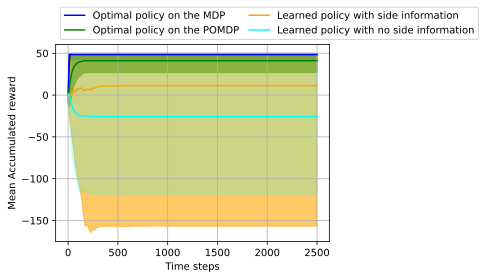

In [22]:
np.random.seed(501)
nb_run = 300
max_iter_per_run = 2500
plt.figure()
plot_pol(pol_val_mdp, color='blue', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=False, label='Optimal policy on the MDP', alpha=1, plot_std=True)
plot_pol(pol_val_opt, color='green', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True, label='Optimal policy on the POMDP', alpha=0.8, plot_std=True)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)
plot_pol(pol_avoidreach_mdp_15, color='orange', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True, label='Learned policy with side information', alpha = 0.6, plot_std=True)
plot_pol(pol_mdp_30, color='cyan', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True, label='Learned policy with no side information', alpha=0.2, plot_std=True)
plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=2, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()